Dependencies for the process

In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from scipy.fft import fft2, fftshift
from scipy.stats import kurtosis
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import shap



In [7]:
# Extraction of the features

# --- Basic Features ---
def two_simple_features(image_path):
    img = Image.open(image_path).convert("RGB")
    gray = np.array(img.convert("L"))
    mean_intensity = float(gray.mean())
    gray_f = gray.astype(np.float32) / 255.0
    gx = cv2.Sobel(gray_f, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    gy = cv2.Sobel(gray_f, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
    mag = np.sqrt(gx**2 + gy**2)
    thresh = 0.2
    edges = (mag > thresh).astype(np.uint8)
    edge_density = float(edges.mean())
    return mean_intensity, edge_density

# --- FFT features ---
def extract_fft_features(image_path):
    img = Image.open(image_path).convert("L")
    arr = np.array(img, dtype=np.float32)
    f = np.abs(fftshift(fft2(arr)))
    f = f / np.sum(f)
    h, w = f.shape
    cy, cx = h // 2, w // 2
    y, x = np.indices((h, w))
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int)
    radial_mean = np.bincount(r.ravel(), f.ravel()) / np.bincount(r.ravel())
    freqs = np.arange(len(radial_mean))
    valid = (radial_mean > 0)
    slope = np.polyfit(np.log(freqs[valid] + 1), np.log(radial_mean[valid]), 1)[0]
    spectral_flatness = np.exp(np.mean(np.log(radial_mean[valid]))) / np.mean(radial_mean[valid])
    hf_ratio = np.sum(radial_mean[-len(radial_mean)//3:]) / np.sum(radial_mean)
    return {"spectral_slope": slope, "spectral_flatness": spectral_flatness, "high_freq_ratio": hf_ratio}

# --- Color Features ---
def extract_color_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r, g, b = img[:,:,0].ravel(), img[:,:,1].ravel(), img[:,:,2].ravel()
    corr_rg = np.corrcoef(r,g)[0,1]
    corr_rb = np.corrcoef(r,b)[0,1]
    corr_gb = np.corrcoef(g,b)[0,1]
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    cb, cr = ycrcb[:,:,2].ravel(), ycrcb[:,:,1].ravel()
    kurt_cb = kurtosis(cb)
    kurt_cr = kurtosis(cr)
    lap_cb = cv2.Laplacian(ycrcb[:,:,2], cv2.CV_64F).ravel()
    lap_cr = cv2.Laplacian(ycrcb[:,:,1], cv2.CV_64F).ravel()
    kurt_lap_cb = kurtosis(lap_cb)
    kurt_lap_cr = kurtosis(lap_cr)
    return {
        "corr_rg": corr_rg, "corr_rb": corr_rb, "corr_gb": corr_gb,
        "kurt_cb": kurt_cb, "kurt_cr": kurt_cr,
        "kurt_lap_cb": kurt_lap_cb, "kurt_lap_cr": kurt_lap_cr
    }

# --- Texture (GLCM) ---
def extract_glcm_features(image_path):
    img = Image.open(image_path).convert("L")
    gray = np.array(img, dtype=np.uint8)
    gray_q = (gray / 4).astype(np.uint8)
    distances = [1,2,4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray_q, distances=distances, angles=angles, levels=64, symmetric=True, normed=True)
    feats = {}
    for prop in ["contrast","homogeneity","energy","correlation"]:
        feats[prop] = graycoprops(glcm, prop).mean()
    return feats

# --- Combined function ---
def extract_all_features(image_path):
    base_f = {}
    base_f["mean_intensity"], base_f["edge_density"] = two_simple_features(image_path)
    fft_f = extract_fft_features(image_path)
    color_f = extract_color_features(image_path)
    glcm_f = extract_glcm_features(image_path)
    all_f = {**base_f, **fft_f, **color_f, **glcm_f}
    return all_f



In [8]:
#Dataframe

rows = []

for folder, label in [("test/ai", 1), ("test/nature", 0)]:
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        if not os.path.isfile(path):
            continue
        feats = extract_all_features(path)
        feats["label"] = label
        feats["file_path"] = path
        rows.append(feats)

df = pd.DataFrame(rows)
df.to_csv("features.csv", index=False)
display(df.head())


C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_6680\3900518750.py:45: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_cb = kurtosis(cb)
C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_6680\3900518750.py:46: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_cr = kurtosis(cr)


,mean_intensity,edge_density,spectral_slope,spectral_flatness,high_freq_ratio,corr_rg,corr_rb,corr_gb,kurt_cb,kurt_cr,kurt_lap_cb,kurt_lap_cr,contrast,homogeneity,energy,correlation,label,file_path
0,118.559893,0.526395,-1.908005,0.024645,0.001295,0.991207,0.964504,0.986513,2.467102,0.611281,0.710121,0.924907,23.725649,0.370923,0.061426,0.946714,1,test/ai\105_midjourney_34.png
1,106.305816,0.687597,-1.376320,0.065857,0.007761,0.975821,0.927388,0.977903,0.273891,0.265245,1.598327,2.714112,46.188584,0.274350,0.057109,0.924207,1,test/ai\109_midjourney_197.png
2,189.429415,0.119762,-1.548670,0.017875,0.001966,0.953788,0.878122,0.972315,4.163840,2.574917,1.676025,1.351951,8.905521,0.722280,0.165075,0.974855,1,test/ai\10_midjourney_169.png
3,108.626329,0.408937,-2.028685,0.018171,0.001156,0.981175,0.565591,0.655224,0.526943,0.415970,2.787242,0.605382,25.949125,0.486363,0.071069,0.955364,1,test/ai\110_midjourney_34.png
4,89.795885,0.213519,-2.056112,0.013164,0.001099,0.813153,0.788791,0.814246,0.413666,-0.701424,0.617873,0.645097,12.566388,0.595585,0.091832,0.964061,1,test/ai\110_midjourney_88.png


In [9]:
#random forest

X = df.drop(columns=["label","file_path"]).values
y = df["label"].values

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

y_pred = cross_val_predict(clf, X, y, cv=cv)

prec, rec, f1, _ = precision_recall_fscore_support(y, y_pred, average="binary")
print(f"Precision: {prec:.3f}  Recall: {rec:.3f}  F1-score: {f1:.3f}")

print("\n=== Classification Report ===")
print(classification_report(y, y_pred, digits=3))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y, y_pred))



Precision: 0.890  Recall: 0.890  F1-score: 0.890

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.890     0.890     0.890       500
           1      0.890     0.890     0.890       500

    accuracy                          0.890      1000
   macro avg      0.890     0.890     0.890      1000
weighted avg      0.890     0.890     0.890      1000


=== Confusion Matrix ===
[[445  55]
 [ 55 445]]



1. Show the metrics and confusion matrix

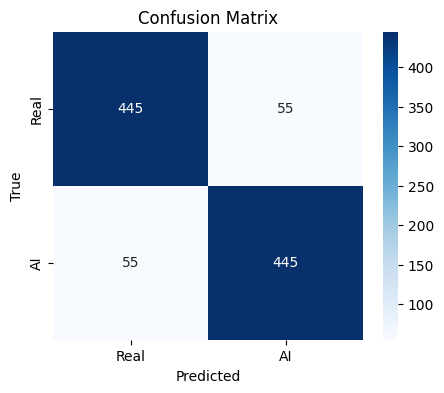

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcula la matriz de confusión
cm = confusion_matrix(y, y_pred, labels=[0,1])

# Gráfico con seaborn
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "AI"], yticklabels=["Real", "AI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



2. Show the importance of features (Gini Importance)

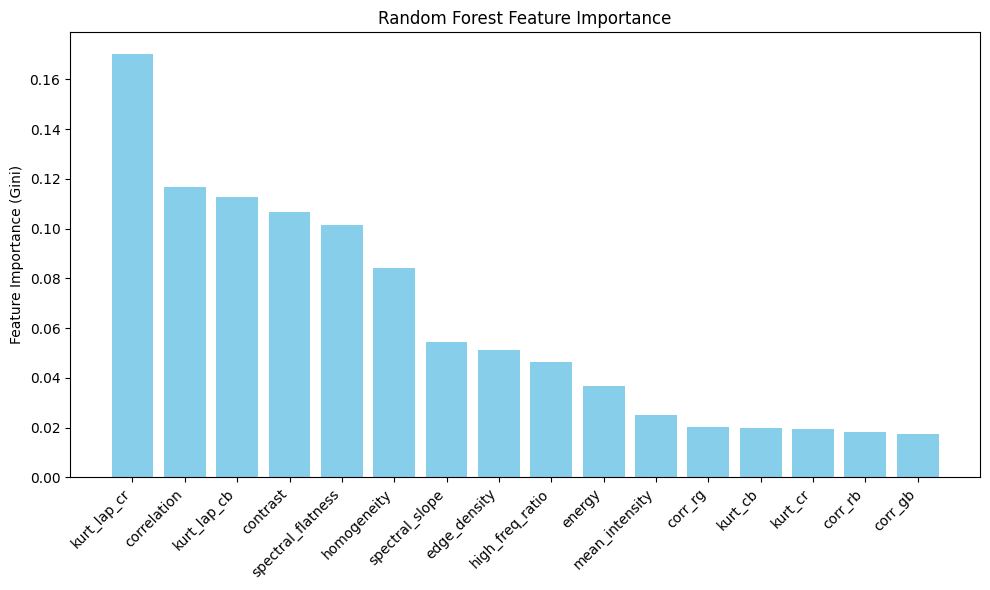

In [35]:
feat_names = df.drop(columns=["label","file_path"]).columns
importances = clf.feature_importances_

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices], color='skyblue', align='center')
plt.xticks(range(len(importances)), feat_names[indices], rotation=45, ha='right')
plt.ylabel("Feature Importance (Gini)")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


3. Boxplots of features in the class

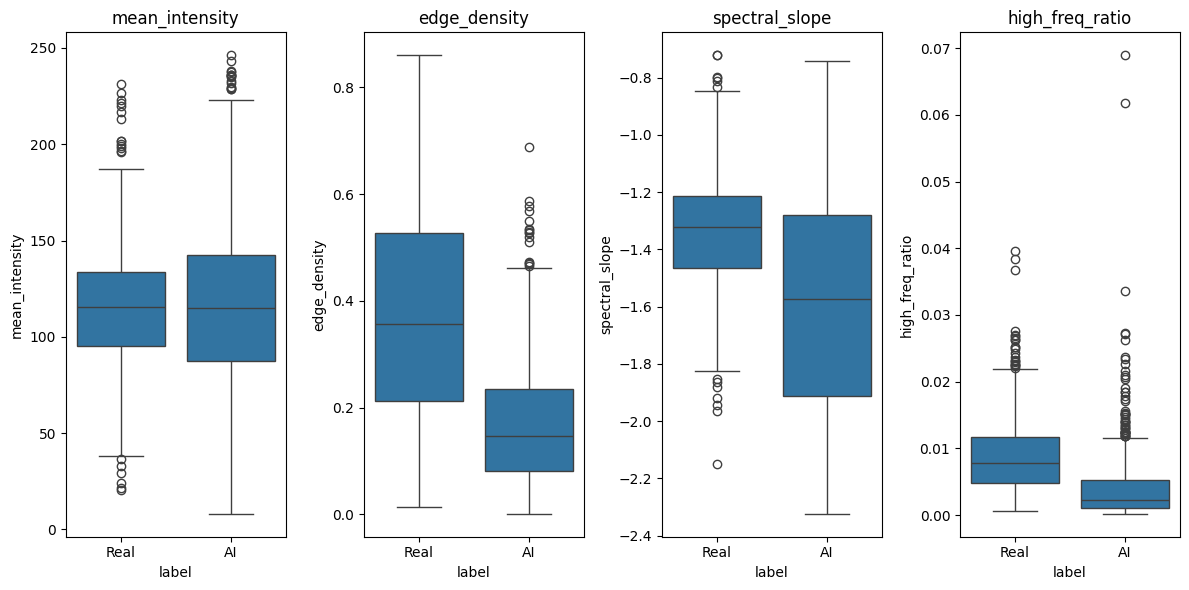

In [36]:
plt.figure(figsize=(12,6))
for i, feat in enumerate(["mean_intensity","edge_density","spectral_slope","high_freq_ratio"]):
    plt.subplot(1,4,i+1)
    sns.boxplot(x="label", y=feat, data=df)
    plt.xticks([0,1], ["Real", "AI"])
    plt.title(feat)
plt.tight_layout()
plt.show()


4. Report table summary

In [37]:
from sklearn.metrics import classification_report
report = classification_report(y, y_pred, target_names=["Real", "AI"], output_dict=True)
metrics_df = pd.DataFrame(report).transpose()
display(metrics_df.round(3))


,precision,recall,f1-score,support
Real,0.89,0.89,0.89,500.00
AI,0.89,0.89,0.89,500.00
accuracy,0.89,0.89,0.89,0.89
macro avg,0.89,0.89,0.89,1000.00
weighted avg,0.89,0.89,0.89,1000.00
